# King's Super Math Saga Experiment

### The Setup

Super Math Saga is a fictional mobile game. Like other Saga games, players need to beat levels to progress through a map. At every level, players are faced with a math question they need to answer correctly to pass to the next level. The game is Free to Play meaning that players can download and play the game for free but can optionally buy hints on the levels.

In 2017 we ran an experiment (A/B Test) on the game, offering two different game experiences that we call A and B, **group A** being the control group where the experience is kept as is, and **group B** being the experiment group that is exposed to the new experience.

We set the assignment process to randomly distribute players among the groups: 80% to group A (control) and 20% to group B (test). The experiment ran from 2017-05-04 to 2017-05-22.

### The Proposed Methodology

The new feature(s) launched for group B may have different effects, depending on the type of player that we study. We should therefore attempt to segment the player base, and conduct hypothesis tests on different cohorts of players, for example:
* New players who downloaded on the day that the AB test took effect
* Players who were already highly engaged but never purchased
* Players who were already regular purchasers

We should also test the effect of the feature changes across different KPIs to get a rounded view of the update's impact. We can break down a headline measure such as 'total purchases' into several drivers, and sub-drivers.

![title](KPIs.png)

All of these five KPIs will be worth exploring.


## 1) Import Required Libraries

In [1]:
#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Standard data manipulations
import pandas as pd
import numpy as np
import copy
from math import log10, floor
pd.set_option('display.float_format', lambda x: '%.6f' % x)

#For accessing the SQL database
from google.cloud import bigquery
bigquery_client = bigquery.Client()

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#For Kolmogorov-Smirnov Test
from scipy import stats

#Callum's personalised visuals settings
from PythonFunctions.cb91visuals import *

#Pickle, for storing test results
import pickle


We can also create a function that will help streamline the process of getting SQL data into a dataframe.

In [3]:
def sql_2_df(query_str, date_index=False, date_name=None):
    '''
    Takes query_str, a string in SQL syntax,
    and returns the output of that query as
    a Pandas dataframe
    
    If the index needs to be a datetime object,
    pass date_index as True, and pass the name
    of the date column
    '''
    
    #Create the query using the string
    query_job = bigquery_client.query(query_str)
    
    #Get this as a dataframe
    temp_df = query_job.to_dataframe()
    
    #Create a date_index if required
    if date_index == True:
        #Set the index to datetime
        temp_df[date_name] = pd.to_datetime(temp_df[date_name], dayfirst=True)

        temp_df.set_index(date_name, drop=True, inplace=True)
    
    #Return the dataframe
    return temp_df


## 2) Sanity Checking The Data

The SQL Schema states that we have two tables' worth of data:

The **assignment** table contains players assigned to the A/B test and attributes related to each player.
* **playerid**: Unique numeric identifier for each player
* **abtest_group**: The group the player was assigned to (A or B)
* **assignment_date**: The date when the player was assigned to the test
* **install_date**: The date when the player installed the game
* **conversion_date**: The date when the player made their first purchase

The **activity** table contains player activity for each day a player was active.
* **playerid**: Unique numeric identifier for each player
* **activity_date**: The date of activity
* **purchases**: Number of purchases made this day
* **gameends**: Number of gamerounds played this day

We should do a few quick checks, just to ensure the data doesn't contain any unexpected quirks.

### Installs by day
Let's see how many installs the game had by day, and how the A/B groups are distributed based on installation date.

In [4]:
df_inst_counts = sql_2_df("""
SELECT
  install_date,
  COUNT(CASE
      WHEN abtest_group = 'A' THEN playerid
    ELSE
    NULL
  END
    ) AS A_players,
  COUNT(CASE
      WHEN abtest_group = 'B' THEN playerid
    ELSE
    NULL
  END
    ) AS B_players
FROM
  abtest.assignment
GROUP BY
  install_date
ORDER BY
  install_date
""", date_index=True, date_name='install_date')


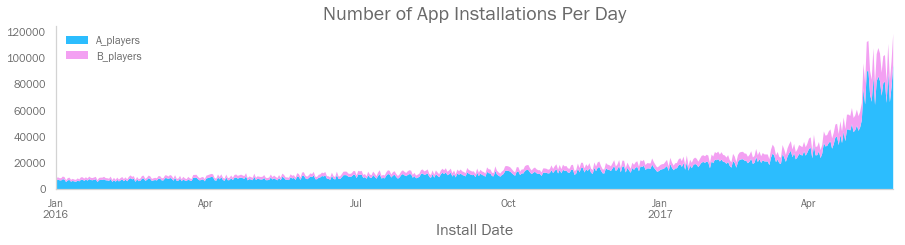

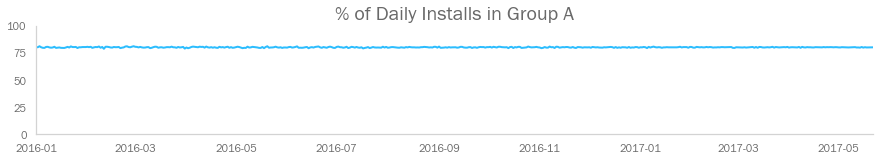

In [5]:
#Plot the results
df_inst_counts.plot.area(figsize=(15,3), lw=0)

plt.legend(frameon=False)
plt.title('Number of App Installations Per Day')
plt.xlabel('Install Date');


#Calculate the share of installs by day in the A group
a_share = df_inst_counts['A_players'] / df_inst_counts.sum(axis=1)

#Plot this share
plt.figure(figsize=(15,2))
plt.plot(df_inst_counts.index, a_share*100, lw=2)
plt.xlim(df_inst_counts.index[0], df_inst_counts.index[-1])
plt.ylim(0,100)
plt.title('% of Daily Installs in Group A');


We see that installs per day were consistent for most of the game's lifetime, and have grown sharply in the last month or two.

The share of players being distributed to group A and B is constant, depending on when the player installed the game.

### Aggregate activity during the AB test period

The AB test period ran from 2017-05-04 to 2017-05-22. Let's examine the activity table and see what the aggregate statistics from that period look like (we'll examine distributions and the difference between A and B groups later).

Note - we can see from this query that we have no random dates in the activity dataset - the earliest date is '2017-04-20' (i.e. two weeks before the AB test) and the latest is '2017-05-22'. Let's look at the activity immediately before the test period (left of the red lines) and during.

activity_date,2017-04-21 00:00:00,2017-05-22 00:00:00
unique_players,6424616.000000,6594125.000000
levels_cleared,84672296.000000,86584660.000000
total_purchases,196625.000000,202805.000000
levels_per_player,13.179355,13.130576
purch_per_1k_player,30.604942,30.755407
purch_per_100k_level,232.218812,234.227402


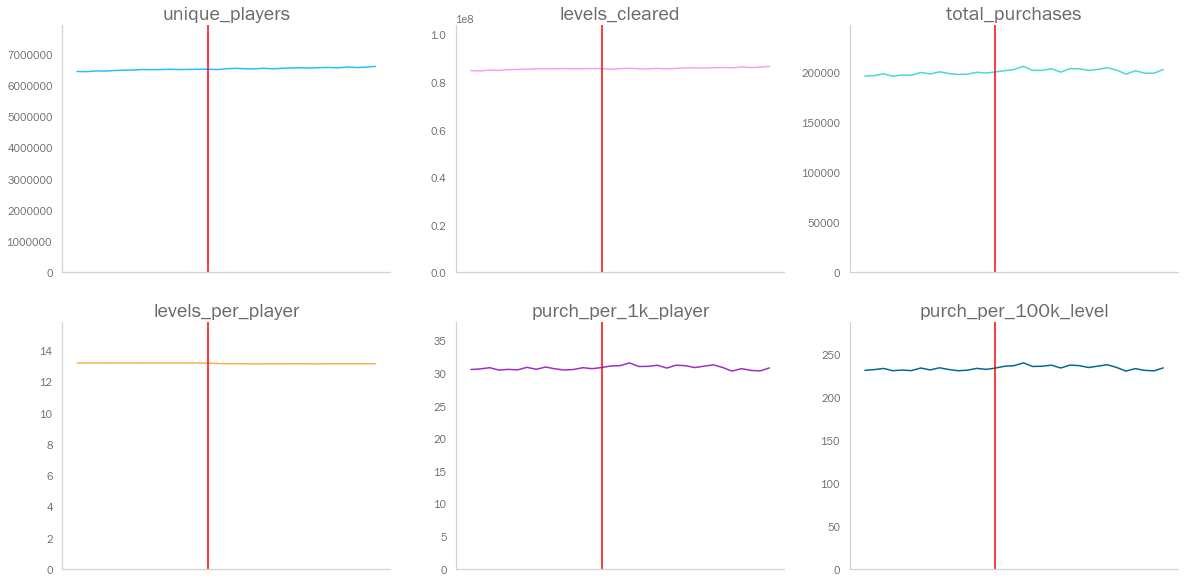

In [6]:
df_test_agg = sql_2_df('''
SELECT
  activity_date,
  count(playerid) as unique_players,
  sum(gameends) as levels_cleared,
  sum(purchases) as total_purchases,
FROM
  abtest.activity
group by
  activity_date
order by
  activity_date''', date_index=True, date_name='activity_date')

#Create additional columns to show other KPIs
df_test_agg['levels_per_player'] = df_test_agg['levels_cleared'] / df_test_agg['unique_players']
df_test_agg['purch_per_1k_player'] = 1000*df_test_agg['total_purchases'] / df_test_agg['unique_players']
df_test_agg['purch_per_100k_level'] = 100000*df_test_agg['total_purchases'] / df_test_agg['levels_cleared']

#Plot these columns
fig, axes = plt.subplots(ncols = 3,
                         nrows = 2,
                         figsize = (20,10))

for i, feature in enumerate(df_test_agg.columns):
        Y = df_test_agg[feature]

        ax = axes[(i)//3][(i)%3]
        ax.plot(df_test_agg.index, Y, color=color_list[i])
        ax.axvline(pd.to_datetime('2017-05-04'), color='red')
        
        ax.set_title(feature)
        ax.set_ylim(0, max(Y)*1.2)
        ax.set_xticks([])
        
df_test_agg.iloc[[1,-1]].T


We can see that, at an aggregate player-base level, there was not much change through the test period across any of the KPIs considered in the overall population (we'll investigate this in more detail in a second).

On average, on a daily basis, Super Math Saga had:
* 6.51m active players
* 86m levels cleared
* 20,000 purchases
* 13 levels completed per active player
* 30 purchases per 1,000 players
* 230 purchases per 100,000 levels completed

## 3) Segmenting the User Base

As previously mentioned, we should investigate the impact of the update on different groups of players.

To this end, we can get the IDs and characteristics of players that fulfil a certain criteria.

### Cohort 1 - New Users

To be in cohort 1, a player must:
* Have installed on 2017-05-04 - the first day of the AB test period.

In [7]:
#Instantiate an empty dictionary with a description of the cohort
#and space to store our hypothesis test results later
cohort1 = {'description': 'Players that installed on day 1 of the test',
          'tests':{}}

#Instantiate a 'data' key, with a sub-dictionary for player IDs,
#dataframes, and distribtions about those players (split by A and B)
cohort1['data'] = {
    'A':{'IDs':None, 'activity':None, 'dists':{}},
    'B':{'IDs':None, 'activity':None, 'dists':{}}
}


#Select players that installed on the first day of the AB test
cohort1['data']['A']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          playerid
                                        FROM
                                          abtest.assignment
                                        WHERE
                                          install_date = '2017-05-04'
                                        AND abtest_group = 'A'""")['playerid'])

cohort1['data']['B']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          playerid
                                        FROM
                                          abtest.assignment
                                        WHERE
                                          install_date = '2017-05-04'
                                        AND abtest_group = 'B'""")['playerid'])


In [8]:
#Get the activity data for each of the A and B group players
cohort1['data']['A']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort1['data']['A']['IDs']}""")

#Get the activity data for each of the A and B group players
cohort1['data']['B']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort1['data']['B']['IDs']}""")
                                          

Having instantiated a dictionary to contain the data about our first cohort, let's start populating the distributions with different KPIs.

To do this, we create functions that will populate our dictionary as required. We will be able to use these for other cohorts.

In [9]:
def active_days_dist(data):
    '''
    Takes a dictionary of IDs and activity
    and returns an array describing how many days
    in the test period each user was active
    '''
    
    #Get the required values from the dictionary
    ids = data['IDs']
    activity = data['activity']
    
    #Calculate the total users and total active
    total_users = len(ids)
    total_active = len(activity['playerid'].unique())
    
    #Calculate if there were any players in the cohort that
    #were never active in the test period
    inactive = total_users - total_active
    
    #Create a list of zeros that we'll add to the distribution
    #to represent these inactive players
    inactive_dist = [0 for i in range(inactive)]
    
    #Group activity df by playerid to count number of active days by player
    active_dist = list(activity.groupby('playerid').count()['activity_date'])
    
    #Combine and return the lists
    return active_dist + inactive_dist


#Let's add these distributions to our dictionary
cohort1['data']['A']['dists']['active_days'] = active_days_dist(cohort1['data']['A'])
cohort1['data']['B']['dists']['active_days'] = active_days_dist(cohort1['data']['B'])



def total_gameends(data):
    '''
    Takes a dataframe of user activity
    and returns an array describing how many levels
    in the test period each user completed
    '''
    
    return list(data.groupby('playerid').sum()['gameends'])

#Let's add these distributions to our dictionary
cohort1['data']['A']['dists']['total_gameends'] = total_gameends(cohort1['data']['A']['activity'])
cohort1['data']['B']['dists']['total_gameends'] = total_gameends(cohort1['data']['B']['activity'])


In [10]:
def gameends_per_day(data):
    '''
    Takes a dataframe of user activity
    and returns an array describing how many levels
    in the test period each user completed per active day
    '''
    
    return list(data.groupby('playerid').mean()['gameends'])

#Let's add these distributions to our dictionary
cohort1['data']['A']['dists']['gameends_per_day'] = gameends_per_day(cohort1['data']['A']['activity'])
cohort1['data']['B']['dists']['gameends_per_day'] = gameends_per_day(cohort1['data']['B']['activity'])



def total_purchases(data):
    '''
    Takes a dataframe of user activity
    and returns an array describing how many purchases
    in the test period each user made
    '''
    return list(data.groupby('playerid').sum()['purchases'])


#Let's add these distributions to our dictionary
cohort1['data']['A']['dists']['total_purchases'] = total_purchases(cohort1['data']['A']['activity'])
cohort1['data']['B']['dists']['total_purchases'] = total_purchases(cohort1['data']['B']['activity'])


In [11]:
def purch_per_day(data):
    '''
    Takes a dataframe of user activity
    and returns an array describing how many purchases
    in the test period each user made per active day
    '''
    
    return list(data.groupby('playerid').mean()['purchases'])

#Let's add these distributions to our dictionary
cohort1['data']['A']['dists']['purch_per_day'] = purch_per_day(cohort1['data']['A']['activity'])
cohort1['data']['B']['dists']['purch_per_day'] = purch_per_day(cohort1['data']['B']['activity'])



def purch_per_level(data):
    '''
    Takes a dataframe of user activity
    and returns an array describing what share of levels
    users made a purchase on during the test period
    '''
    
    #Sum the total purchases and levels passed by player
    temp_df = data.groupby('playerid').sum()
    
    #Remove players who passed no levels
    temp_df = temp_df.loc[temp_df['gameends']>0]
    
    #Divide total purchases by total level
    temp_df['purch_per_level'] = temp_df['purchases'] / temp_df['gameends']
    return list(temp_df['purch_per_level'])


#Let's add these distributions to our dictionary
cohort1['data']['A']['dists']['purch_per_level'] = purch_per_level(cohort1['data']['A']['activity'])
cohort1['data']['B']['dists']['purch_per_level'] = purch_per_level(cohort1['data']['B']['activity'])


### Cohort 2 - Freeloaders

This cohort will consist of players who were highly active in the fortnight up to the AB test period, but had not ever made a purchase.

To be in cohort 2, a player must:
* Have been active every day for the two weeks up to the AB test
* Have passed at least 5 levels a day
* Have never made a purchase before the start of the test

In [12]:
#Instantiate an empty dictionary with a description of the cohort
cohort2 = {'description': 'Players who were highly active in the fortnight up to the AB test period, but had not ever made a purchase',
          'tests':{}}
        
#Instantiate a 'data' key, with a sub-dictionary for player IDs
#dataframes, and distribtions about those players (split by A and B)
cohort2['data'] = {
    'A':{'IDs':None, 'activity':None, 'dists':{}},
    'B':{'IDs':None, 'activity':None, 'dists':{}}
}


#Select players that match the required criteria
cohort2['data']['A']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          activity.playerid
                                        FROM
                                          abtest.activity
                                        LEFT JOIN
                                          abtest.assignment
                                        USING
                                          (playerid)
                                        WHERE
                                          activity_date < '2017-05-04'
                                          AND abtest_group = 'A'
                                          AND (assignment.conversion_date IS NULL
                                            OR assignment.conversion_date >= '2017-05-04')
                                        GROUP BY
                                          activity.playerid
                                        HAVING
                                          COUNT(gameends) = 14
                                          AND MIN(activity.gameends) >= 5""")['playerid'])

cohort2['data']['B']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          activity.playerid
                                        FROM
                                          abtest.activity
                                        LEFT JOIN
                                          abtest.assignment
                                        USING
                                          (playerid)
                                        WHERE
                                          activity_date < '2017-05-04'
                                          AND abtest_group = 'B'
                                          AND (assignment.conversion_date IS NULL
                                            OR assignment.conversion_date >= '2017-05-04')
                                        GROUP BY
                                          activity.playerid
                                        HAVING
                                          COUNT(gameends) = 14
                                          AND MIN(activity.gameends) >= 5""")['playerid'])


In [13]:
#Get the activity data for each of the A and B group players
cohort2['data']['A']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort2['data']['A']['IDs']}""")

#Get the activity data for each of the A and B group players
cohort2['data']['B']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort2['data']['B']['IDs']}""")
                                          

We can then use the previously constructed functions to populate the required distributions for this cohort.

In [14]:
cohort2['data']['A']['dists']['active_days'] = active_days_dist(cohort2['data']['A'])
cohort2['data']['B']['dists']['active_days'] = active_days_dist(cohort2['data']['B'])

cohort2['data']['A']['dists']['total_gameends'] = total_gameends(cohort2['data']['A']['activity'])
cohort2['data']['B']['dists']['total_gameends'] = total_gameends(cohort2['data']['B']['activity'])

cohort2['data']['A']['dists']['gameends_per_day'] = gameends_per_day(cohort2['data']['A']['activity'])
cohort2['data']['B']['dists']['gameends_per_day'] = gameends_per_day(cohort2['data']['B']['activity'])

cohort2['data']['A']['dists']['total_purchases'] = total_purchases(cohort2['data']['A']['activity'])
cohort2['data']['B']['dists']['total_purchases'] = total_purchases(cohort2['data']['B']['activity'])

cohort2['data']['A']['dists']['purch_per_day'] = purch_per_day(cohort2['data']['A']['activity'])
cohort2['data']['B']['dists']['purch_per_day'] = purch_per_day(cohort2['data']['B']['activity'])

cohort2['data']['A']['dists']['purch_per_level'] = purch_per_level(cohort2['data']['A']['activity'])
cohort2['data']['B']['dists']['purch_per_level'] = purch_per_level(cohort2['data']['B']['activity'])


### Cohort 3 - Heavy Purchasers

This cohort will consist of players that made a lot of purchases in the fortnight leading up to the AB test.

To be in cohort 3, a player must:
* Have made at least 7 purchases in the two weeks up to the start of the test period.
* Have played at least 7 days out of the two weeks up to the start of the test period.

In [15]:
#Instantiate an empty dictionary with a description of the cohort
cohort3 = {'description': 'Players that made a lot of purchases in the fortnight leading up to the AB test.',
           'tests':{}}

#Instantiate a 'data' key, with a sub-dictionary for player IDs
#dataframes, and distribtions about those players (split by A and B)
cohort3['data'] = {
    'A':{'IDs':None, 'activity':None, 'dists':{}},
    'B':{'IDs':None, 'activity':None, 'dists':{}}
}


#Select players that match the required criteria
cohort3['data']['A']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          activity.playerid
                                        FROM
                                          abtest.activity
                                        LEFT JOIN
                                          abtest.assignment
                                        USING
                                          (playerid)
                                        WHERE
                                          install_date < '2017-04-20'
                                          AND activity_date < '2017-05-04'
                                          AND abtest_group = 'A'
                                        GROUP BY
                                          activity.playerid
                                        HAVING
                                          sum(purchases) >= 7
                                          and COUNT(gameends) >= 7""")['playerid'])

cohort3['data']['B']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          activity.playerid
                                        FROM
                                          abtest.activity
                                        LEFT JOIN
                                          abtest.assignment
                                        USING
                                          (playerid)
                                        WHERE
                                          install_date < '2017-04-20'
                                          AND activity_date < '2017-05-04'
                                          AND abtest_group = 'B'
                                        GROUP BY
                                          activity.playerid
                                        HAVING
                                          sum(purchases) >= 7
                                          and COUNT(gameends) >= 7""")['playerid'])


In [16]:


#Get the activity data for each of the A and B group players
cohort3['data']['A']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort3['data']['A']['IDs']}""")

#Get the activity data for each of the A and B group players
cohort3['data']['B']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort3['data']['B']['IDs']}""")


In [17]:
#Let's get the required distributions
cohort3['data']['A']['dists']['active_days'] = active_days_dist(cohort3['data']['A'])
cohort3['data']['B']['dists']['active_days'] = active_days_dist(cohort3['data']['B'])

cohort3['data']['A']['dists']['total_gameends'] = total_gameends(cohort3['data']['A']['activity'])
cohort3['data']['B']['dists']['total_gameends'] = total_gameends(cohort3['data']['B']['activity'])

cohort3['data']['A']['dists']['gameends_per_day'] = gameends_per_day(cohort3['data']['A']['activity'])
cohort3['data']['B']['dists']['gameends_per_day'] = gameends_per_day(cohort3['data']['B']['activity'])

cohort3['data']['A']['dists']['total_purchases'] = total_purchases(cohort3['data']['A']['activity'])
cohort3['data']['B']['dists']['total_purchases'] = total_purchases(cohort3['data']['B']['activity'])

cohort3['data']['A']['dists']['purch_per_day'] = purch_per_day(cohort3['data']['A']['activity'])
cohort3['data']['B']['dists']['purch_per_day'] = purch_per_day(cohort3['data']['B']['activity'])

cohort3['data']['A']['dists']['purch_per_level'] = purch_per_level(cohort3['data']['A']['activity'])
cohort3['data']['B']['dists']['purch_per_level'] = purch_per_level(cohort3['data']['B']['activity'])


### Cohort 4 - Convertibles

This cohort will consist of players that made no purchases immediately before the test period, but had previously made a purchase.

To be in cohort 4, a player must:
* Have made at least 0 purchases in the two weeks up to the start of the test period.
* Have a non-null conversion date BEFORE the two weeks up to the start of the test period.
* Have completed at least 1 level in the two weeks up to the start of the test period.

In [18]:
#Instantiate an empty dictionary with a description of the cohort
cohort4 = {'description': 'Players that made no purchases immediately before the test period, but had previously converted.',
           'tests':{}}

#Instantiate a 'data' key, with a sub-dictionary for player IDs
#dataframes, and distribtions about those players (split by A and B)
cohort4['data'] = {
    'A':{'IDs':None, 'activity':None, 'dists':{}},
    'B':{'IDs':None, 'activity':None, 'dists':{}}
}


#Select players that match the required criteria
cohort4['data']['A']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          activity.playerid
                                        FROM
                                          abtest.activity
                                        LEFT JOIN
                                          abtest.assignment
                                        USING
                                          (playerid)
                                        WHERE
                                          install_date < '2017-04-20'
                                          AND activity_date < '2017-05-04'
                                          AND conversion_date < '2017-05-04'
                                          AND abtest_group = 'A'
                                        GROUP BY
                                          activity.playerid
                                        HAVING
                                          sum(purchases) = 0
                                          and sum(gameends) > 0""")['playerid'])

cohort4['data']['B']['IDs'] = tuple(sql_2_df("""
                                        SELECT
                                          activity.playerid
                                        FROM
                                          abtest.activity
                                        LEFT JOIN
                                          abtest.assignment
                                        USING
                                          (playerid)
                                        WHERE
                                          install_date < '2017-04-20'
                                          AND activity_date < '2017-05-04'
                                          AND conversion_date < '2017-05-04'
                                          AND abtest_group = 'B'
                                        GROUP BY
                                          activity.playerid
                                        HAVING
                                          sum(purchases) = 0
                                          and sum(gameends) > 0""")['playerid'])


In [19]:
#Get the activity data for each of the A and B group players
cohort4['data']['A']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort4['data']['A']['IDs']}""")

#Get the activity data for each of the A and B group players
cohort4['data']['B']['activity'] = sql_2_df(f"""
                                        SELECT
                                          *
                                        FROM
                                          abtest.activity
                                        WHERE
                                          playerid in {cohort4['data']['B']['IDs']}""")
                                          

In [20]:
#Let's get the required distributions
cohort4['data']['A']['dists']['active_days'] = active_days_dist(cohort4['data']['A'])
cohort4['data']['B']['dists']['active_days'] = active_days_dist(cohort4['data']['B'])

cohort4['data']['A']['dists']['total_gameends'] = total_gameends(cohort4['data']['A']['activity'])
cohort4['data']['B']['dists']['total_gameends'] = total_gameends(cohort4['data']['B']['activity'])

cohort4['data']['A']['dists']['gameends_per_day'] = gameends_per_day(cohort4['data']['A']['activity'])
cohort4['data']['B']['dists']['gameends_per_day'] = gameends_per_day(cohort4['data']['B']['activity'])

cohort4['data']['A']['dists']['total_purchases'] = total_purchases(cohort4['data']['A']['activity'])
cohort4['data']['B']['dists']['total_purchases'] = total_purchases(cohort4['data']['B']['activity'])

cohort4['data']['A']['dists']['purch_per_day'] = purch_per_day(cohort4['data']['A']['activity'])
cohort4['data']['B']['dists']['purch_per_day'] = purch_per_day(cohort4['data']['B']['activity'])

cohort4['data']['A']['dists']['purch_per_level'] = purch_per_level(cohort4['data']['A']['activity'])
cohort4['data']['B']['dists']['purch_per_level'] = purch_per_level(cohort4['data']['B']['activity'])


## 4) Exploring Distributions

Having constructed our distributions of the different player cohorts, we should now explore them.

In particular, we can check that our sample sizes are sensible, and investigate the characteristics of the distributions - in particular, whether or not they are normally distributed.

In [21]:
def n_sigfig(x, n):
    '''
    Rounds x to n significant figures
    '''
    if x==0:
        return 0
    elif x<0:
        x = abs(x)
        return -round(x, -int(floor(log10(x))) + (n - 1))
    else:
        return round(x, -int(floor(log10(x))) + (n - 1))
    
    
def sample_sizes(cohorts):
    
    '''
    Takes a list of cohorts and returns a dataframe showing
    A / B sample sizes in each cohort
    '''
    
    #Instantiate lists that we'll use to construct our dataframe
    cohort_number = []
    A_sizes = []
    B_sizes = []
    
    #For the different cohorts
    for i, cohort in enumerate(cohorts):
        
        #Append appropriate lists with cohort name
        #and lengths of A/B IDs
        cohort_number.append(i+1)
        A_sizes.append(len(cohort['data']['A']['IDs']))
        B_sizes.append(len(cohort['data']['B']['IDs']))
    
    #Create the dataframe
    df = pd.DataFrame({'Cohort':cohort_number,
                      'n_A':A_sizes,
                      'n_B':B_sizes})
    
    #Calculate the share of A and B in each cohort
    df['A%'] = df['n_A'] / (df['n_A'] + df['n_B'])
    df['B%'] = df['n_B'] / (df['n_A'] + df['n_B'])
    
    df.set_index('Cohort', drop=True, inplace=True)
                       
    return df


Let's double check how many players are in the A and B groups of each cohort.

In [22]:
sample_sizes([cohort1, cohort2, cohort3, cohort4])


,n_A,n_B,A%,B%
Cohort,,,,
1,76809,19114,0.800736,0.199264
2,71882,17644,0.802918,0.197082
3,63421,15740,0.801165,0.198835
4,7699,1856,0.805756,0.194244


Thus, it seems that our cohorts do not have bias, with regards to whether or not they contain a higher or lower share of A or B group players.

In [23]:
def ks_test(X):
    '''
    Takes a distribution X, assumes that it is normal.
    Thus, transforms it to a standard normal, and performs
    Kolmogorov-Smirnov test, returning p-value of H0
    (high value means likely that distribtion is indeed normal)
    '''
    
    #Make sure distribution is in an array
    if type(X) == list:
        X = np.array(X)
    
    #Calculate the mean and standard deviation
    mu = X.mean()
    s = X.std()
    
    #Standardise the data
    X_normed = (X-mu) / s
    
    #Perform the KS test
    test = stats.kstest(X_normed, 'norm')
    
    #Return the required p-value
    return test[1]


def normal_check(cohort, alpha = 0.05):
    '''
    Takes a cohort, and works out if the distributions
    of its KPIs are normal or not, to a given level
    of confidence, alpha
    '''
    
    kpis = []
    p_values = []
    conclusions = []
    
    #For each kpi...
    for kpi in list(cohort['data']['A']['dists'].keys()):

            kpis.append(kpi)
            
            #Extract the distribution and combine the groups
            As = cohort['data']['A']['dists'][kpi]
            Bs = cohort['data']['B']['dists'][kpi]
            X = As + Bs
            
            #perform the ks test
            p_value = ks_test(X)
            p_values.append(p_value)
            
            if p_value > alpha:
                conclusions.append('Normal')
            else:
                conclusions.append('Not Normal')
                
    df = pd.DataFrame({'KPI':kpis,
                      'P-Value':p_values,
                      'Conclusion':conclusions})
    
    return df


In [24]:
def plot_kdes(cohort, size=(20,8), hist=True):
    
    '''
    Takes a cohort dictionary, and plots KDEs of the
    A and B groups of each cohort, with the means of each
    cohort displayed in the chart title
    '''
    
    #Plot these columns
    fig, axes = plt.subplots(ncols = 3,
                             nrows = 2,
                             figsize = size)

    fig.subplots_adjust(hspace=0.4)

    kpis = list(cohort['data']['A']['dists'].keys())
    
    #For each kpi in the cohort
    for i, kpi in enumerate(kpis):
        #Get the data, and calcualte the means of this data
        kpi_A = cohort['data']['A']['dists'][kpi]
        kpi_B = cohort['data']['B']['dists'][kpi]

        mean_A = n_sigfig(np.array(kpi_A).mean(),3)
        mean_B = n_sigfig(np.array(kpi_B).mean(),3)
        
        #Plot the histograms for the data on the appropriate axis
        ax = axes[(i)//3][(i)%3]
        if hist == True:
            ax.hist(kpi_A, bins=100, alpha=0.5, density=True)
            ax.hist(kpi_A, bins=100, alpha=0.5, density=True)
        else:
            sns.kdeplot(kpi_A, ax=ax, bw=1)
            sns.kdeplot(kpi_B, ax=ax, bw=1)
            
        #Cut x-lims to show the min and max values
        ax.set_xlim(0, max(max(kpi_A),max(kpi_B)))

        title = f"{kpi.replace('_',' ').title()}\nMeans: A={mean_A}, B={mean_B}"
        ax.set_title(title)
        

Let's now go through our cohorts one by one, and for each, see if any of the KPIs are normally distributed.

Players that installed on day 1 of the test


,KPI,P-Value,Conclusion
0,active_days,0.000000,Not Normal
1,total_gameends,0.000000,Not Normal
2,gameends_per_day,0.000000,Not Normal
3,total_purchases,0.000000,Not Normal
4,purch_per_day,0.000000,Not Normal
5,purch_per_level,0.000000,Not Normal


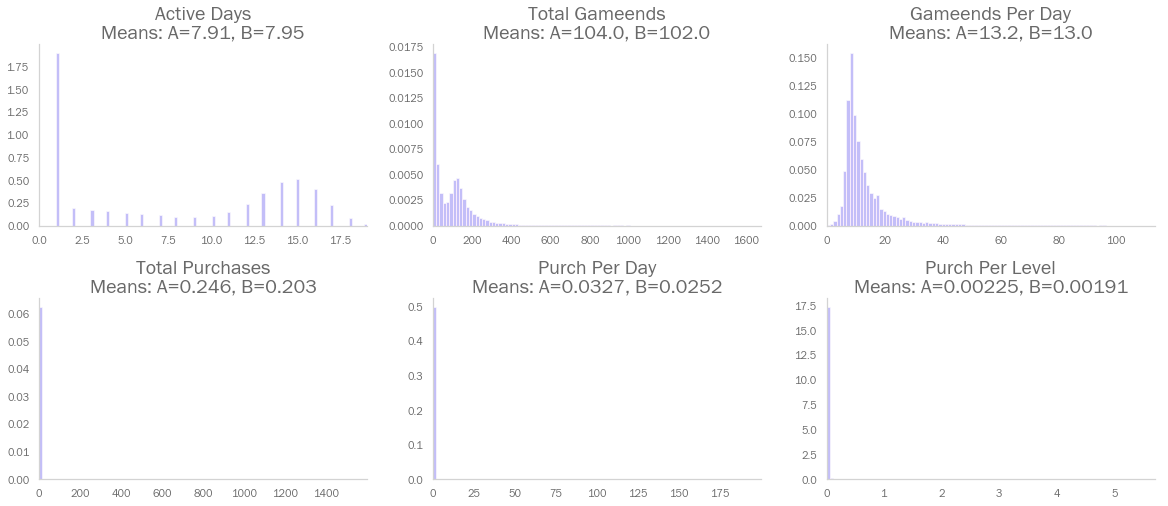

In [25]:
print(cohort1['description'])
plot_kdes(cohort1)
normal_check(cohort1)


Players who were highly active in the fortnight up to the AB test period, but had not ever made a purchase


,KPI,P-Value,Conclusion
0,active_days,0.000000,Not Normal
1,total_gameends,0.000000,Not Normal
2,gameends_per_day,0.000000,Not Normal
3,total_purchases,0.000000,Not Normal
4,purch_per_day,0.000000,Not Normal
5,purch_per_level,0.000000,Not Normal


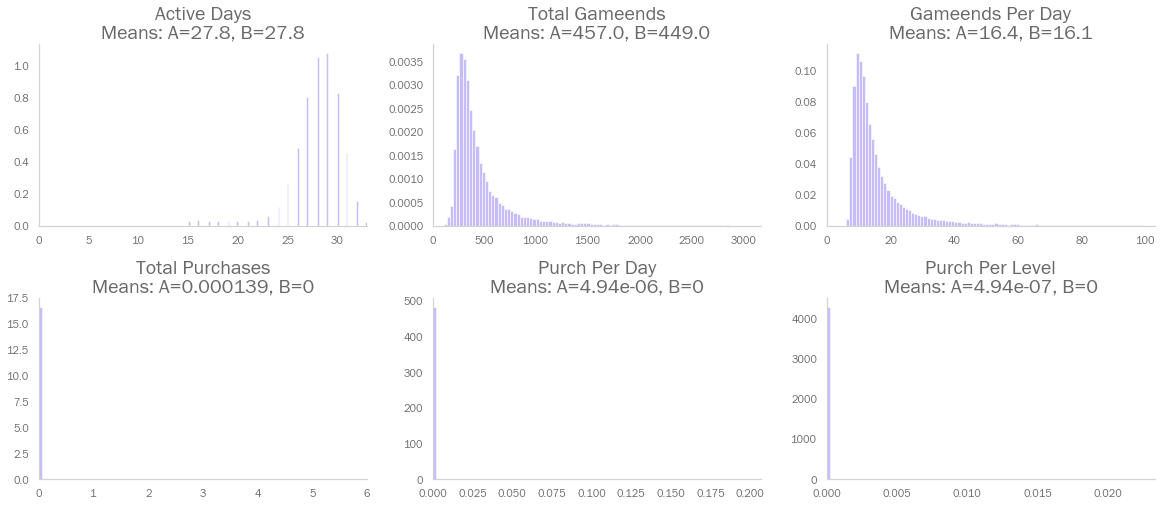

In [26]:
print(cohort2['description'])
plot_kdes(cohort2)
normal_check(cohort2)


Players that made a lot of purchases in the fortnight leading up to the AB test.


,KPI,P-Value,Conclusion
0,active_days,0.000000,Not Normal
1,total_gameends,0.000000,Not Normal
2,gameends_per_day,0.000000,Not Normal
3,total_purchases,0.000000,Not Normal
4,purch_per_day,0.000000,Not Normal
5,purch_per_level,0.000000,Not Normal


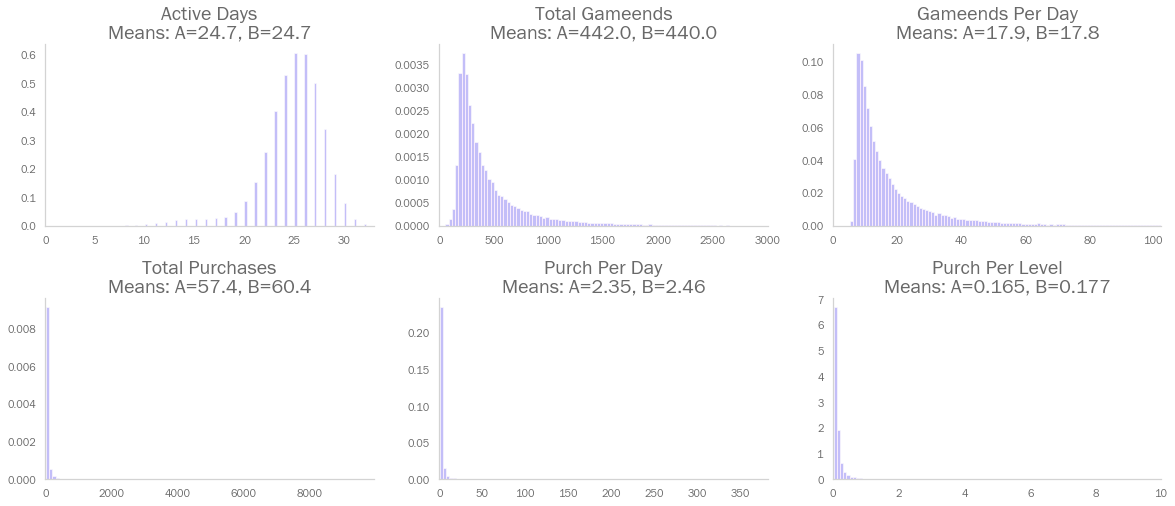

In [27]:
print(cohort3['description'])
plot_kdes(cohort3)
normal_check(cohort3)


Players that made no purchases immediately before the test period, but had previously converted.


,KPI,P-Value,Conclusion
0,active_days,0.000000,Not Normal
1,total_gameends,0.000000,Not Normal
2,gameends_per_day,0.000000,Not Normal
3,total_purchases,0.000000,Not Normal
4,purch_per_day,0.000000,Not Normal
5,purch_per_level,0.000000,Not Normal


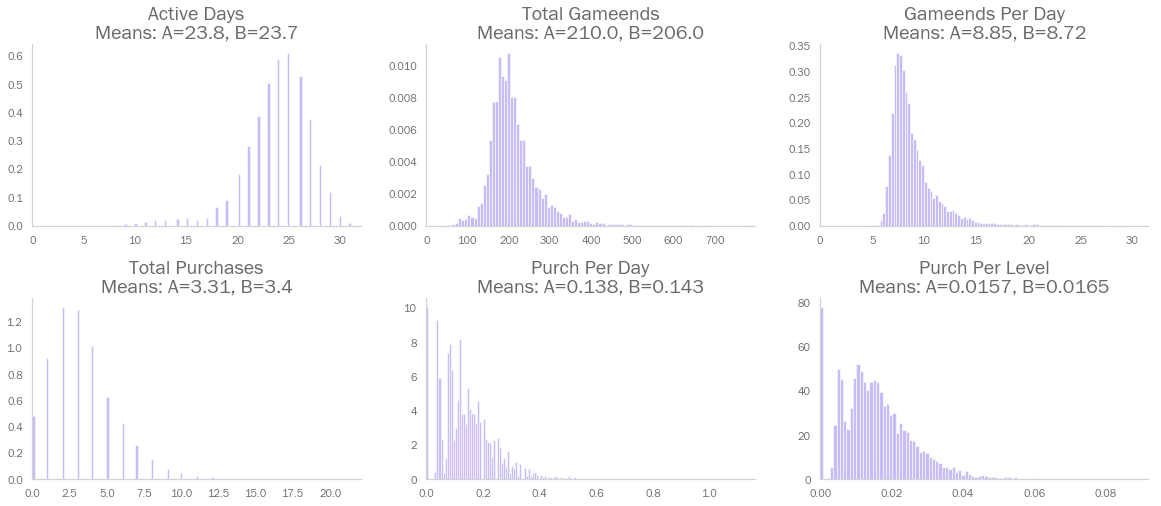

In [28]:
print(cohort4['description'])
plot_kdes(cohort4)
normal_check(cohort4)


Aside from anything else, we should note that, although there are slight differences, the distributions of A and B groups are very similar across KPIs and cohorts.

## 5) Permutation Tests With Monte Carlo Simulations

We have seen above that none of the distributions are normal, thus many of the assumptions that we would require in order to make inferences with parametric tests are violated. We thus need to resort to non-parametric tests.

The following functions will help us to conduct permutation tests to test statistical significance, using Monte Carlo simulations.

In [29]:
def subtract_list(full_list, sub_list, return_as_array=True):
    
    '''
    Take one list (full_list),
    and "remove" another (sub_list) from it.
    
    e.g. subtract_list([1,1,3,5,5,6,7], [1,5,6])
         returns [1,3,5,7]
         
    sub_array must be a sub-set of the full_array
    '''
    #Ensure that inputs are lists
    if type(full_list) != list:
        full_list = list(full_list)
        
    if type(sub_list) != list:
        sub_list = list(sub_list)
    
    #Create a deepcopy of the sub_list to avoid unintended
    #effects of remove function
    sub = copy.deepcopy(sub_list)
    
    #Use a list comprehension to remove the elements
    #in the sublist from the full list
    new_list = [i for i in full_list if i not in sub or sub.remove(i)]
    
    #Cast as array if we need to, before returning
    if return_as_array == True:
        return np.array(new_list)
    else:
        return new_list
    

In [30]:
def monte_carlo(A, B, n = 10000, A_x_than_B = 'greater'):
    
    '''
    Run a monte carlo simulation on two samples, and return a p_value
    that the mean of population A is bigger than population B
    
    INPUTS:
        A (numpy array or list):
        The first sample (the one we expect to be larger)

        B (numpy array or list):
        The second sample (the one we expect to be smaller)

        n (integer):
        The number of simulations that should be run
        
        A_x_than_B (string):
        -'greater' if we are testing that A is greater than B
        -'less' if we are testing that A is less than B
    '''
    
    #Test to see if samples are given as lists, and convert to numpy arrays if so:
    if type(A) == list:
        A = np.array(A)
    if type(B) == list:
        B = np.array(B)
        
    #Calculate the true mean difference for comparison later
    mean_diff = np.mean(A) - np.mean(B)
    
    #Combine the two samples into a single array
    data = np.concatenate((A, B))
    
    #Instantiate a list of samples with same length as sample B
    new_Bs = []
    
    #Take n random samples equal to length of sample B from the combined array
    for i in range(n):
        new_Bs.append(np.random.choice(data, len(B), replace=False))
    
    #Given our list of new_B samples, create an equivalent list of new_As.
    #These are the 'complimentary sets' of elements, relative to the new_Bs.
    new_As = [subtract_list(data, i) for i in new_Bs]
    
    #Create a list of these new combinations
    new_combs = [(new_As[i], new_Bs[i]) for i in range(n)]
    
    #Calculate the differences between their means
    comb_diffs = np.array([np.mean(i[0]) - np.mean(i[1]) for i in new_combs])
    
    #Work out the share of the comb_diffs that are larger or smaller than the original mean_diff
    if A_x_than_B == 'greater':
        return sum(comb_diffs > mean_diff) / n
    if A_x_than_B == 'less':
        return sum(comb_diffs < mean_diff) / n
    

In [31]:
def monte_carlos(A, B, n_list = [10,50,100,500,1000],
                 A_x_than_B = None):
    
    '''
    Runs a series of monte carlo simulation on two samples,
    and return a p_values that the mean of population A is different
    to population B over various values of n.
    
    INPUTS:
        A (numpy array or list):
        The first sample (the one we expect to be larger)

        B (numpy array or list):
        The second sample (the one we expect to be smaller)

        n_list (list):
        The number of simulations that should be run
        
        A_x_than_B (string):
        -None will result in automatic selection based on which mean is higher
        -'greater' if we are testing that A is greater than B
        -'less' if we are testing that A is less than B
    '''
    
    if A_x_than_B == None:
        if np.array(A).mean() > np.array(B).mean():
            A_x_than_B = 'greater'
        else:
            A_x_than_B = 'less'            
    
    #Instantiate a dictionary of p_values
    p_values = {}
    
    #Iterate through the values of n, creating key value
    #pairs for the number of simulations, and assocated p_values
    for i in n_list:
        new_value = monte_carlo(A, B, i, A_x_than_B)
        p_values[i] = new_value
        
    return p_values


Let's use these to automate the running of Monte Carlo Simulations.

Note - we comment out some of this code after running so that it doesn't run again...

In [32]:
#For each cohort...
for i, cohort in enumerate([cohort1, cohort2, cohort3, cohort4]):

    #Look at each KPI in turn
    for kpi in list(cohort['data']['A']['dists'].keys()):
        
#         #Extract the required distributions
#         A_dist = cohort['data']['A']['dists'][kpi]
#         B_dist = cohort['data']['B']['dists'][kpi]
        
#         #And run monte carlo simulations to conduct the permutation test
#         MCS = monte_carlos(A_dist, B_dist)
        
#         #And also pickle, so we don't have to run again
#         with open(f'Simulations/cohort{i+1}_{kpi}.pickle', 'wb') as f:
#             pickle.dump(MCS, f, pickle.HIGHEST_PROTOCOL)
            
        with open(f'Simulations/cohort{i+1}_{kpi}.pickle', 'rb') as f:
            MCS = pickle.load(f)
            
        #Store this in the dictionary
        cohort['tests'][kpi] = MCS
        
        print(f"cohort{i+1} {kpi} completed and saved")
        

cohort1 active_days completed and saved
cohort1 total_gameends completed and saved
cohort1 gameends_per_day completed and saved
cohort1 total_purchases completed and saved
cohort1 purch_per_day completed and saved
cohort1 purch_per_level completed and saved
cohort2 active_days completed and saved
cohort2 total_gameends completed and saved
cohort2 gameends_per_day completed and saved
cohort2 total_purchases completed and saved
cohort2 purch_per_day completed and saved
cohort2 purch_per_level completed and saved
cohort3 active_days completed and saved
cohort3 total_gameends completed and saved
cohort3 gameends_per_day completed and saved
cohort3 total_purchases completed and saved
cohort3 purch_per_day completed and saved
cohort3 purch_per_level completed and saved
cohort4 active_days completed and saved
cohort4 total_gameends completed and saved
cohort4 gameends_per_day completed and saved
cohort4 total_purchases completed and saved
cohort4 purch_per_day completed and saved
cohort4 purc

Let's explore the results.

In [33]:
def summary_table(cohorts, alpha=0.05, sort=True):
    
    '''
    Summarises the permutation tests
    and shows which effects were statistically
    signficant to a given alpha rate
    '''

    
    kpis = []
    cohort_group = []
    changes = []
    abs_differences = []
    pc_differences = []
    p_vals = []
    stat_sig = []
    
    for i, cohort in enumerate(cohorts):
        
        for kpi in cohort['tests'].keys():
            
            cohort_group.append(i+1)
            kpis.append(f"{kpi.replace('_',' ').title()}")
            
            A_mean = np.array(cohort['data']['A']['dists'][kpi]).mean()
            B_mean = np.array(cohort['data']['B']['dists'][kpi]).mean()

            if A_mean < B_mean:
                changes.append('B Higher')
            else:
                changes.append('B Lower')
                        
            abs_differences.append(B_mean - A_mean)
            pc_differences.append((B_mean - A_mean) / A_mean)
            
            p_value = list(cohort['tests'][kpi].items())[-1][1]
            p_vals.append(p_value)
            
            if p_value > alpha:
                stat_sig.append(0)
            else:
                stat_sig.append(1)
    
    df = pd.DataFrame({'Cohort':cohort_group,
                       'KPI':kpis,
                       'FeatureEffect':changes,
                       'AbsDifference':abs_differences,
                       '%Difference':pc_differences,
                       'P-Value':p_vals,
                       'Significant':stat_sig})
                        
    
    if sort == True:
        df = df.sort_values(['KPI', 'Cohort', 'Significant', 'P-Value'],
                            ascending=[True,True,False,True])
                        
        df.reset_index(drop=True, inplace=True)
    
    return df
                        

First, let's see if any of the tests produced significant results.

In [34]:
df_sum = summary_table([cohort1, cohort2, cohort3, cohort4])
df_sum.loc[df_sum['Significant']==1]


,Cohort,KPI,FeatureEffect,AbsDifference,%Difference,P-Value,Significant
4,1,Gameends Per Day,B Lower,-0.212891,-0.016170,0.004000,1
5,2,Gameends Per Day,B Lower,-0.287548,-0.017521,0.000000,1
7,4,Gameends Per Day,B Lower,-0.134939,-0.015239,0.015000,1
9,2,Purch Per Day,B Lower,-0.000005,-1.000000,0.000000,1
10,3,Purch Per Day,B Higher,0.117484,0.050047,0.030000,1
11,4,Purch Per Day,B Higher,0.004628,0.033469,0.031000,1
13,2,Purch Per Level,B Lower,-0.000000,-1.000000,0.000000,1
14,3,Purch Per Level,B Higher,0.011801,0.071591,0.000000,1
15,4,Purch Per Level,B Higher,0.000818,0.052095,0.000000,1
17,2,Total Gameends,B Lower,-8.192163,-0.017936,0.000000,1


In [35]:
def plot_perm_test(cohort, alpha=0.05, size=(20,10)):
    
    '''
    Produces a plot showing the p-values for the various number of 
    simulations (n) run during given monte-carlo simulation-based
    permutation tests across a cohort.
    
    INPUTS:
        cohort (dictionary):
        The cohort that we want to explore.

        alpha (float):
        The alpha level we want to graph.
    
    '''
        
    #Plot these columns
    fig, axes = plt.subplots(ncols = 3,
                             nrows = 2,
                             figsize = size)

    fig.subplots_adjust(hspace=0.5)
    
    #For each KPI...
    for i, kpi in enumerate((cohort['tests'].keys())):
        
        #Get the n levels and p-values for the x axis
        A_mean = np.array(cohort['data']['A']['dists'][kpi]).mean()
        B_mean = np.array(cohort['data']['B']['dists'][kpi]).mean()
        pc_diff = 100*(B_mean-A_mean)/A_mean
        
        if A_mean < B_mean:
            change = f'Test Group {abs(n_sigfig(pc_diff,3))}% Higher'
        else:
            change = f'Test Group {abs(n_sigfig(pc_diff,3))}% Lower'
        
        
        X = [i[0] for i in list(cohort['tests'][kpi].items())]
        Y = [i[1] for i in list(cohort['tests'][kpi].items())]

        ax = axes[(i)//3][(i)%3]
        
        #Plot the curve showing how p-values change
        #with increasing numbers of simulations
        ax.plot(X, Y, color=color_list[i])
        ax.axhline(alpha, color='red', ls='--', lw=0.5)
        ax.set_xscale('log')
        
        ax.set_xlabel('# Simulations In Perm Test (log scale)')
        ax.set_ylabel('P-value')
        ax.set_ylim(0,1)
        
        title = f"{kpi.replace('_',' ').title()}\n{change}"
        ax.set_title(title)


Let's create visuals of these tests.

Remember - any plots that end up below the red line (y=0.05) would be statistically significant, with 95% confidence. We would expect that, as you move along the x-axis, the plot tends to its actual value.

Players that installed on day 1 of the test


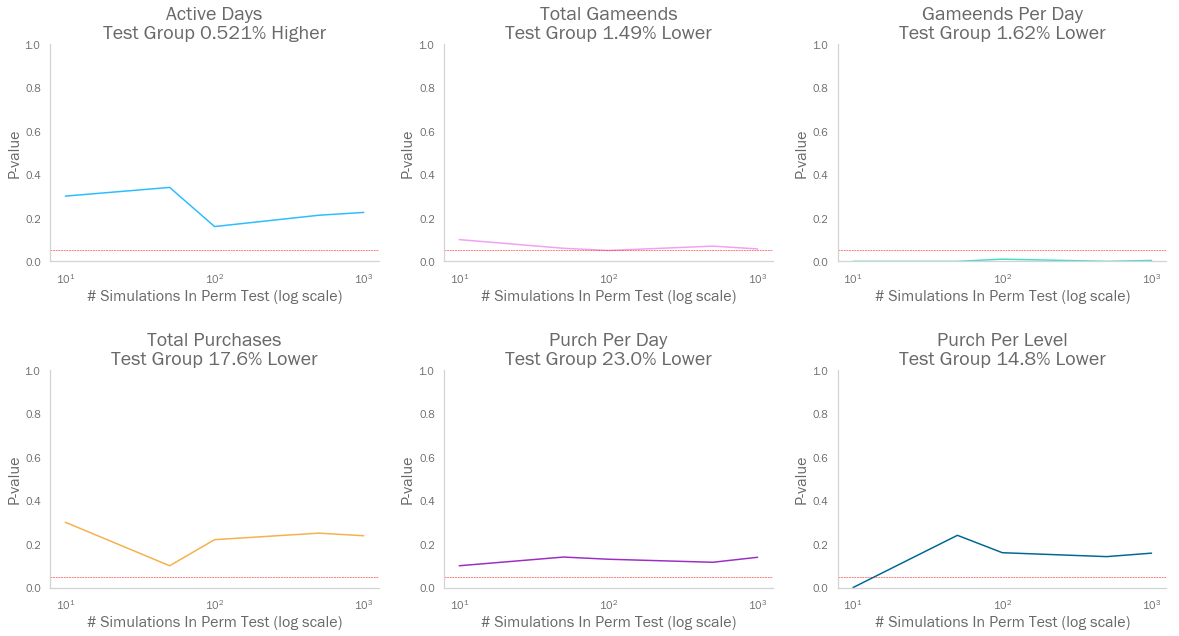

In [36]:
plot_perm_test(cohort1)
print(cohort1['description'])


Players who were highly active in the fortnight up to the AB test period, but had not ever made a purchase


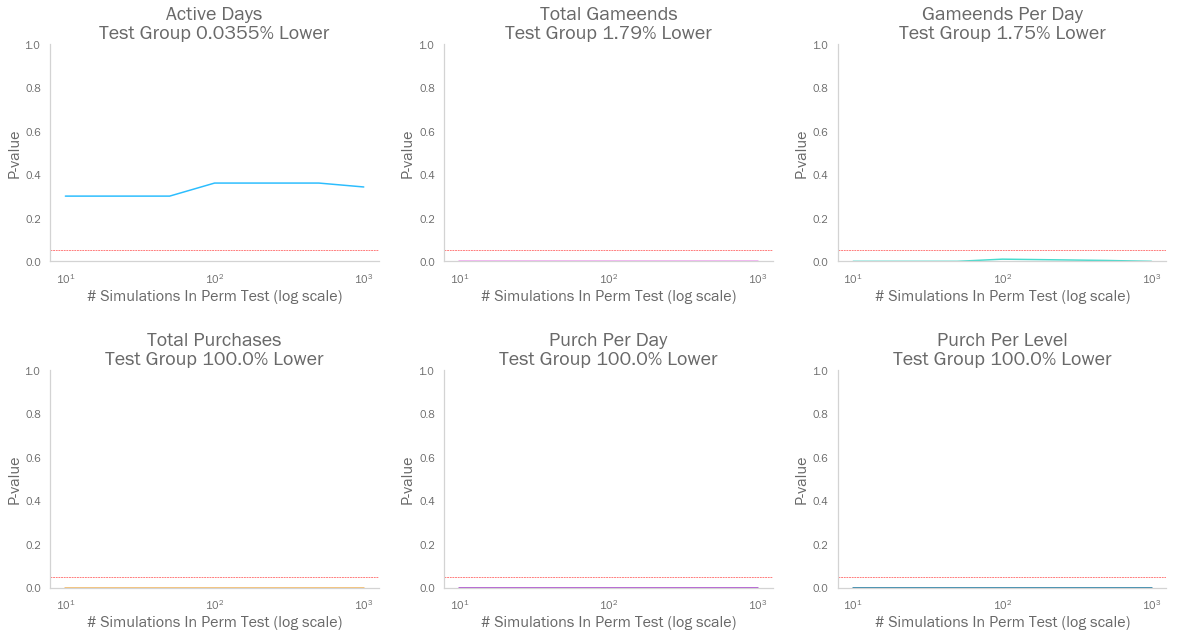

In [37]:
plot_perm_test(cohort2)
print(cohort2['description'])


Players that made a lot of purchases in the fortnight leading up to the AB test.


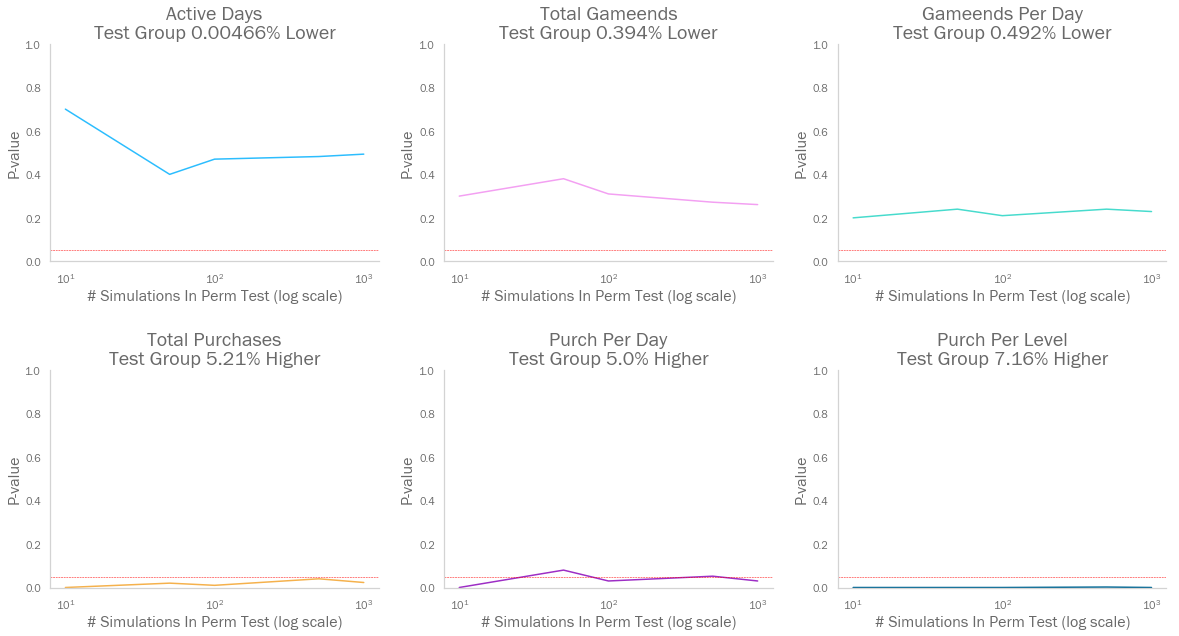

In [38]:
plot_perm_test(cohort3)
print(cohort3['description'])


Players that made no purchases immediately before the test period, but had previously converted.


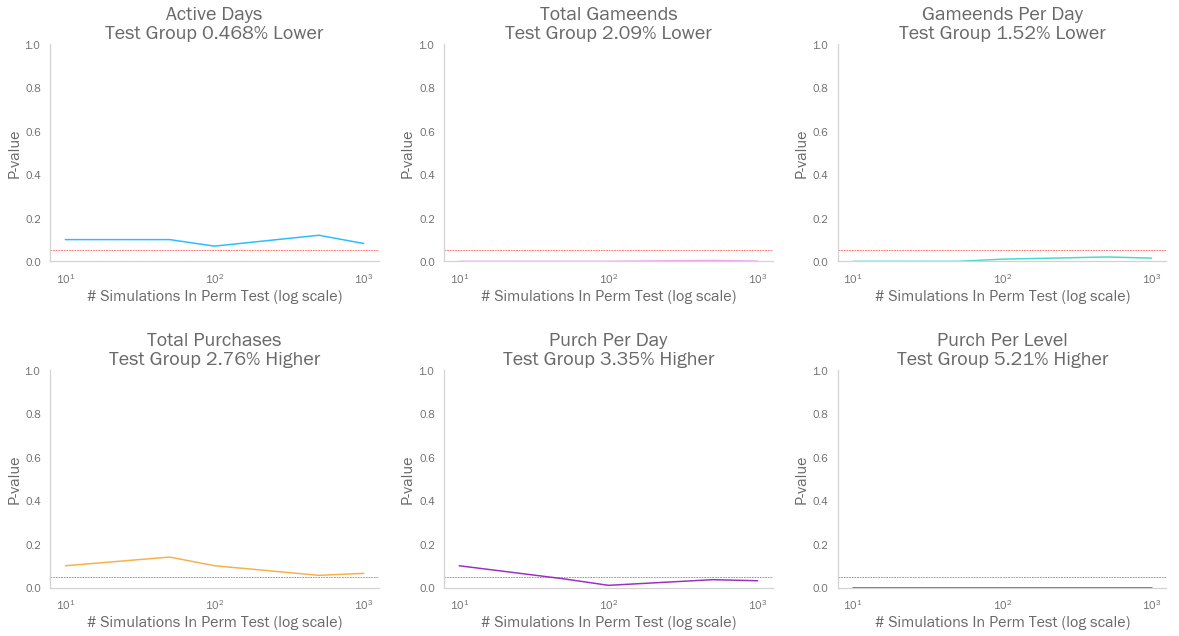

In [39]:
plot_perm_test(cohort4)
print(cohort4['description'])


## 6) Conclusion

We have seen that the game feature change had different impacts on different player cohorts.

* It resulted in an increase in purchases amongst Heavy Purchasers – an extra 3 per cohort player over the test period (+5%), driven by an extra purchase every 100 levels, on average.

* However, the test group completed 1.5% to 1.7% fewer levels per day in all other cohorts.

* It also made Freeloaders less likely to purchase.

![title](Conclusion.png)

It is possible that the feature deployed to the test group was designed to make certain levels slightly harder (possibly deployed alongside a purchasable ‘booster’), which provided an opportunity for converted players to ‘pay-to-play’, but discouraged the progress of players who don’t typically pay.

Thus, the net impact of the new feature was ambiguous – customers with an existing propensity to make purchases increased their spend, but at the cost of other players’ engagement.

We can solidify our analysis and conclusions by:
* Increasing the number of simulations in the permutation tests, ideally to 10,000 per KPI, rather than 1,000 (computing power limited this).
* Attempting paired T-Tests that investigate the ∆ across the different cohorts / KPIs between the two weeks before the test start, and the first two weeks of the feature being deployed.
* Investigating the LTV of converted players and the primary triggers for conversion, to see what kind of decrease in engagement is acceptable in exchange for increased revenues from paying players.
* Refactoring code for re-usability. Take an object-oriented approach by creating a cohort ‘class’ that automatically generates distributions, visualisations, and hypothesis tests upon object instantiation.